# Create a population density mask for Australia

In [1]:
import xarray as xr
import numpy as np
from pyproj import Transformer
import xesmf as xe

import matplotlib.pyplot as plt

We use the file from the ABS: https://www.abs.gov.au/statistics/people/population/regional-population/2021-22#cite-window1 (Australian population grid 2022 in GeoTIFF format) [Accessed 06/07/2023]

In [62]:
# Open tif and drop band dimension
pop = xr.open_rasterio(
    "/g/data/w42/dr6273/work/data/ABS/ABS_population_density/apg22r_1_0_0.tif",
    # chunks={"x": 500, "y": 200}
).squeeze("band", drop=True)

/jobfs/90041262.gadi-pbs/ipykernel_460140/1551775163.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  pop = xr.open_rasterio(


Total population - looks right

In [65]:
pop.where(pop>0).sum()

<xarray.DataArray ()>
array(25996150., dtype=float32)

Ocean cells are masked with -1, and many land cells are 0 (no population density). To check what we have is sensible, set the scale max to 3:

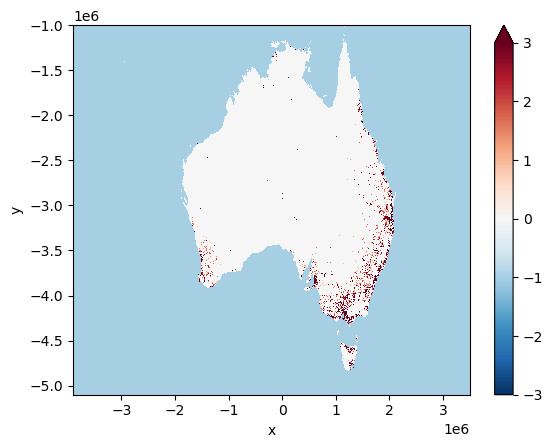

In [66]:
pop.plot.imshow(vmax=3)

According to the attributes, this raster is in the coordinate system EPSG:3577, which in in metres: https://epsg.io/3577

We want to transform to EPSG:4326, which is in lat/lon: https://epsg.io/4326

In [67]:
transformer = Transformer.from_crs("EPSG:3577", "EPSG:4326", always_xy=True)

Apply the transformation - this takes quite a bit of time, so first reduce the size of the array using `.sel` with trial and error of the values, to get as close to Australia as possible.

In [68]:
subset = pop.isel(
    x=range(1950, 6050),
    y=range(100, 3900)
)

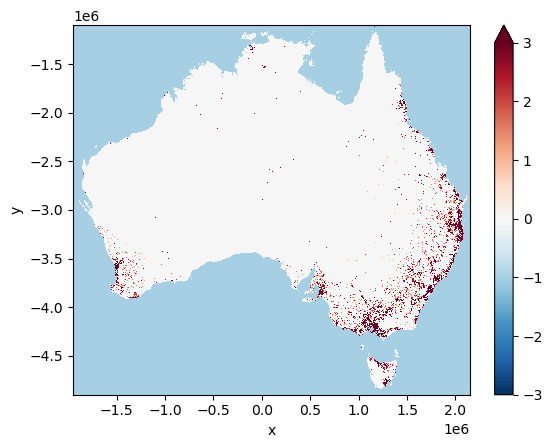

In [26]:
subset.plot.imshow(vmax=3)

In [27]:
# Create rectangular grid
X, Y = np.meshgrid(subset.x.values, subset.y.values)

In [28]:
# We have gone from a 4100x7401 grid to 3800x4100
print(X.shape, Y.shape)

(3800, 4100) (3800, 4100)


The transform takes 1.25 hours

In [29]:
%%time
lon, lat = transformer.transform(X, Y)

CPU times: user 12min 19s, sys: 10min 32s, total: 22min 51s
Wall time: 1h 15min 29s


In [30]:
subset.coords['lat'] = (subset.dims, lat)
subset.coords['lon'] = (subset.dims, lon)

Write to file so we don't have to compute again

In [40]:
subset.to_dataset(name="population_density").to_netcdf("/g/data/w42/dr6273/work/data/ABS/ABS_population_density/apg22r_1_0_0.nc")

### Regrid to ERA5

In [2]:
# Open the new netcdf file
pop = xr.open_dataset("/g/data/w42/dr6273/work/data/ABS/ABS_population_density/apg22r_1_0_0.nc")

In [3]:
# Check population
pop.where(pop > 0)["population_density"].sum()

<xarray.DataArray 'population_density' ()>
array(25989126., dtype=float32)

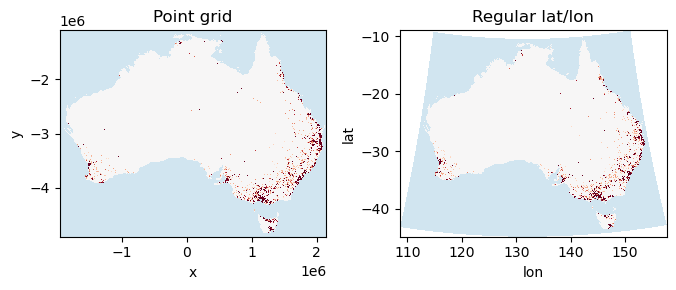

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

pop["population_density"].plot.imshow(ax=ax[0], add_colorbar=False, vmax=5)
pop["population_density"].plot.pcolormesh("lon", "lat", ax=ax[1], add_colorbar=False, vmax=5)

ax[0].set_title("Point grid")
ax[1].set_title("Regular lat/lon")

plt.tight_layout()

Get ERA5 template and subset for Australia

In [56]:
template = xr.open_dataset(
    "/g/data/rt52/era5/single-levels/monthly-averaged/2t/1959/2t_era5_moda_sfc_19590101-19590131.nc"
)

In [57]:
template = template["t2m"].sel(longitude=slice(108, 158), latitude=slice(-8, -45))

Use the coordinates to set up the desired output grid

In [58]:
ds_out = xr.Dataset({
    "lat": (["lat"], template["latitude"].values, {"units": "degrees_north"}),
    "lon": (["lon"], template["longitude"].values, {"units": "degrees_east"}),
})

Do the regridding

In [59]:
%%time
regridder =  xe.Regridder(pop, ds_out, "nearest_d2s")

CPU times: user 1min 11s, sys: 1.11 s, total: 1min 12s
Wall time: 1min 12s


In [60]:
pop_era = regridder(pop, keep_attrs=True)

Check population again

In [61]:
pop_era.where(pop_era > 0)["population_density"].sum()

<xarray.DataArray 'population_density' ()>
array(25883452., dtype=float32)

Set ocean to zero instead of NaN

In [70]:
pop_era = pop_era.where(pop_era.notnull(), 0)

Check this looks ok

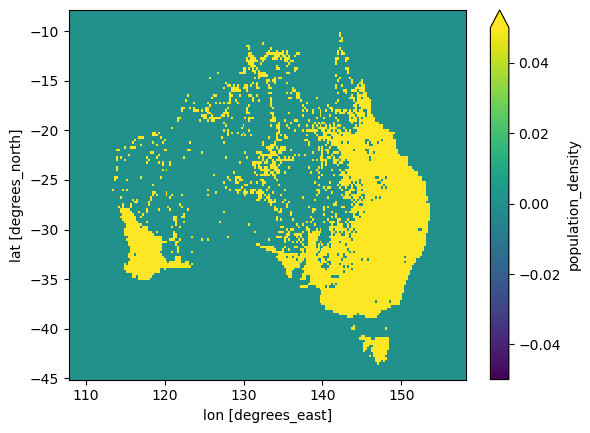

In [74]:
# Looks like there are a lot of cells with someone living there... Unrealistic?
pop_era["population_density"].plot(vmax=0)

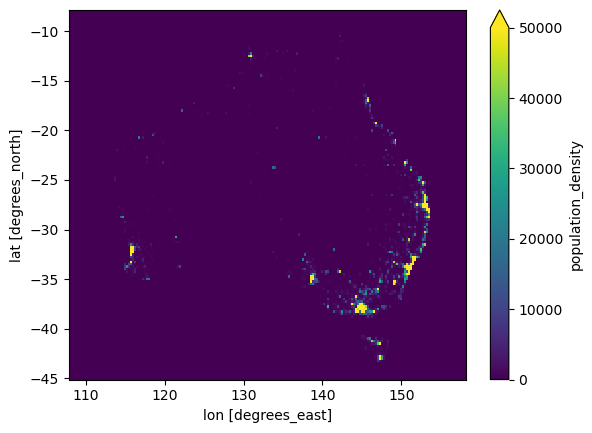

In [78]:
# But those will be weighted very small. Overall looks OK?
pop_era["population_density"].plot(vmax=50000)